# Лабораторная работа №7
Численное решение краевой задачи, реализовать решение ОДУ сеточным методом.
- Начинать вычисления с грубой сетки (примерно 10 интервалов); измельчать сетку и уточнять по Ричардсону. В идеале — до момента выхода на ошибки округления. Отследить, какая точность (например, от $10^{−2}$ до $10^{−6}$) достигнута при каком шаге сетки.
- Выводить полученное приближение.

Решаем дифференциальное уравнение вида: $$−p(x)y′′+q(x)y′+r(x)y=f(x).$$

In [70]:
import seaborn as sns
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from scipy.linalg import hilbert
import unittest
from parameterized import parameterized, parameterized_class
from tabulate import tabulate
import numpy.testing
import matplotlib as mpl

plt.style.use('default')
sns.color_palette('bright')

def run_test(TestCase):
    test_runner = unittest.TextTestRunner(verbosity=2)
    test_runner.run(unittest.makeSuite(TestCase))

In [71]:
def grid(a, b, N):
    return np.linspace(a, b, N)

def solve_using_grid(a, b, p, q, r, f, N, alpha, beta):
    g = grid(a, b, N)
    lhs = np.zeros((N + 1, N + 1))
    F = np.zeros((N + 1, 1))
    h = (b - a) / N
    lhs[0, 0] = 1
    lhs[N, N] = 1
    F[0] = alpha
    F[N] = beta

    for n in range(1, N):
        x = g[n]
        lhs[n, n + 1] = p(x) / h ** 2  + q(x) / (2 * h) # u_n+1
        lhs[n, n] = -2 * p(x) / h ** 2 - r(x) # u_n
        lhs[n, n - 1] = p(x) / h ** 2 - q(x) / (2 * h) # u_n-1
        F[n] = f(x)

    return np.linalg.solve(lhs, F)

def error(v1, v2, r=2, p=1):
    N = v2.size
    delta = np.zeros((N, 1))
    for i in range(0, N, 2):
        delta[i] = (v2[i] - v1[i // 2]) / (r ** p - 1)
    for i in range(1, N, 2):
        delta[i] = (delta[i - 1] + delta[i + 1]) / 2

    return delta

def error_norm(v1, v2, r=2, p=1):
    N = v2.size
    return np.linalg.norm(error(v1, v2, r, p), ord=2) / math.sqrt(N)

def solve(a, b, p, q, r, f, alpha, beta, eps, max_iterations=100):
    n = 10

    v1 = solve_using_grid(a, b, p, q, r, f, n, alpha, beta)
    v2 = solve_using_grid(a, b, p, q, r, f, 2 * n, alpha, beta)
    intervals = [2 * n]
    errors = [error_norm(v1, v2)]
    i = 0
    while i < max_iterations:
        n *= 2
        i += 1
        if error_norm(v1, v2) < eps:
            break
        if i == max_iterations:
            break
        v1 = v2
        v2 = solve_using_grid(a, b, p, q, r, f, 2 * n, alpha, beta)
        intervals.append(2 * n)
        errors.append(error_norm(v1, v2))

    # уточняем решение
    v2 = v2 + error(v1, v2)
    return v2, intervals, errors

In [72]:
from math import sin, exp, sqrt

def test_name(testcase_func, param_num, param):
    eps = str(param.args[0])
    return "%s_%s" %(
        testcase_func.__name__,
        parameterized.to_safe_name(f'eps={eps}')
    )

class GridTestCase(unittest.TestCase):
    def test_simple(self):
        p = lambda x: x - 1
        q = lambda x: -x
        r = lambda x: 1
        f = lambda x: (x - 1) ** 2
        a, b = 0, 0.5
        alpha, beta = 0, 0
        actual = lambda x: -1 + exp(x) + (5 * x)/2 - 2 * sqrt(math.e) * x - x ** 2
        actual = np.vectorize(actual)

        x, intervals, errors = solve(a, b, p, q, r, f, alpha, beta, 1e-6, max_iterations=10)
        N = intervals[-1] + 1
        g = grid(a, b, N)
        expected = actual(g).reshape((N, 1))
        np.testing.assert_allclose(x, expected, atol=1e-2)

run_test(GridTestCase)

test_simple (__main__.GridTestCase) ... ok

----------------------------------------------------------------------
Ran 1 test in 21.793s

OK


In [76]:
def plot(a, b, actual, intervals, errors, expected=None):
    fig, ax = plt.subplots(1, 2, figsize=(30, 10), dpi=80)
    N = intervals[-1] + 1
    solution_ax = ax[0]
    error_ax = ax[1]
    g = grid(a, b, N)
    solution_ax.title.set_text('Решение диффура')
    solution_ax.set_xlabel('x', fontsize=20)
    solution_ax.set_ylabel('y', fontsize=20)
    solution_ax.plot(g, actual, label='Найденное решение')

    if expected:
        solution_ax.plot(g, expected(g), label='Точное решение')
    solution_ax.legend(prop={'size': 20})

    error_ax.title.set_text('Зависимость ошибки от количества узлов сетки')
    error_ax.set_yscale('log')
    error_ax.set_xscale('log', basex=2)
    error_ax.set_xlabel('Количество узлов', fontsize=20)
    error_ax.set_ylabel('Оценка точности ответа', fontsize=20)
    error_ax.plot(intervals, errors)


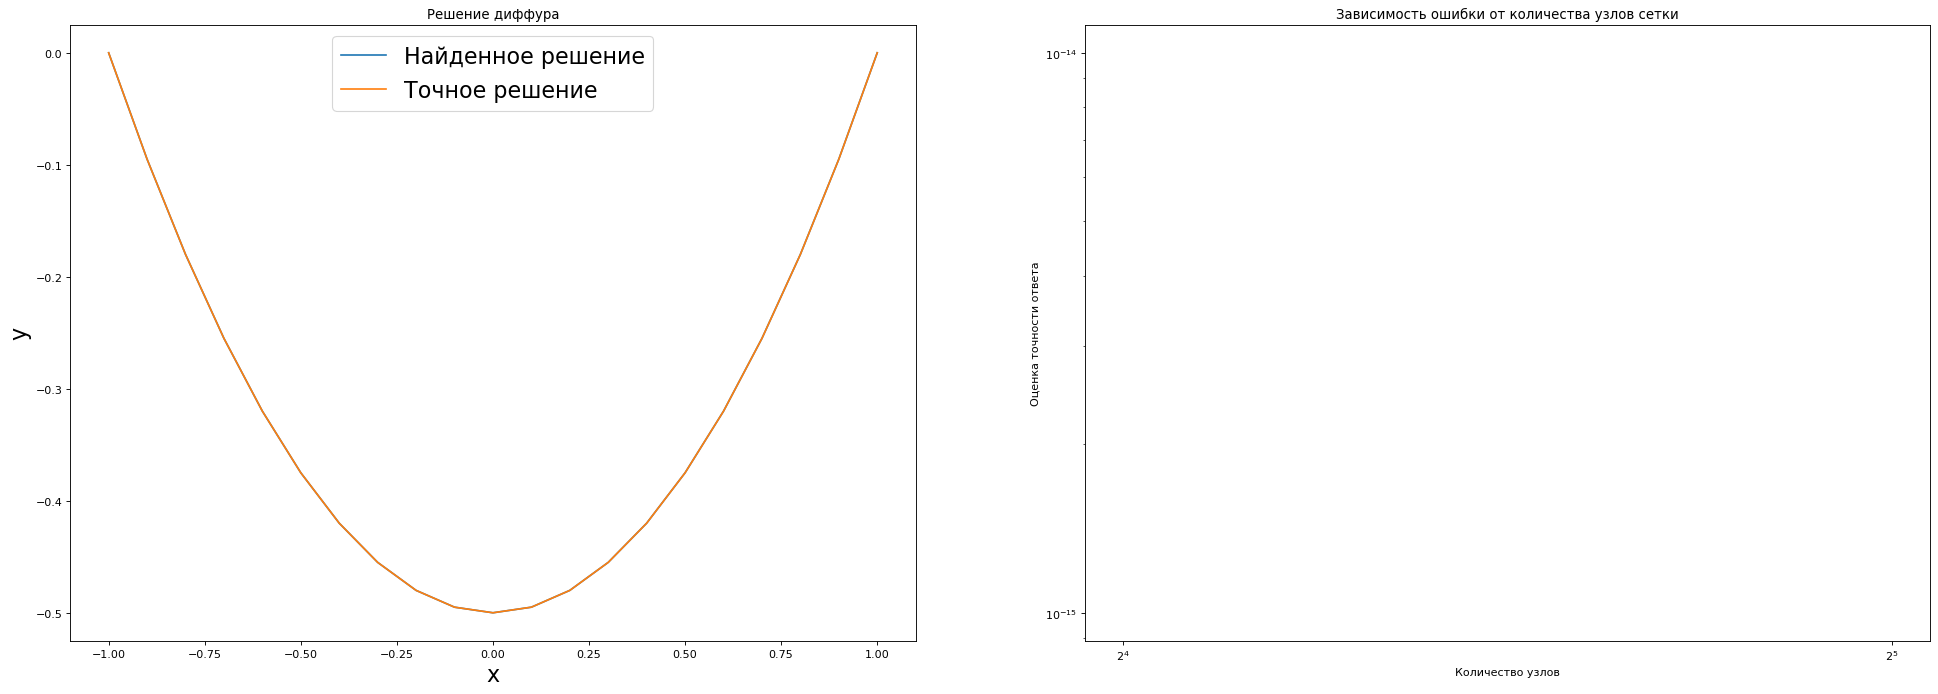

In [81]:
# u'' = 1
p = lambda x: 1
q = lambda x: 0
r = lambda x: 0
f = lambda x: 1
expected = lambda x: (x ** 2 - 1) / 2

a, b = -1, 1
alpha, beta = 0, 0
x, intervals, errors = solve(a, b, p, q, r, f, alpha, beta, 1e-6)
plot(a, b, x, intervals, errors, expected)

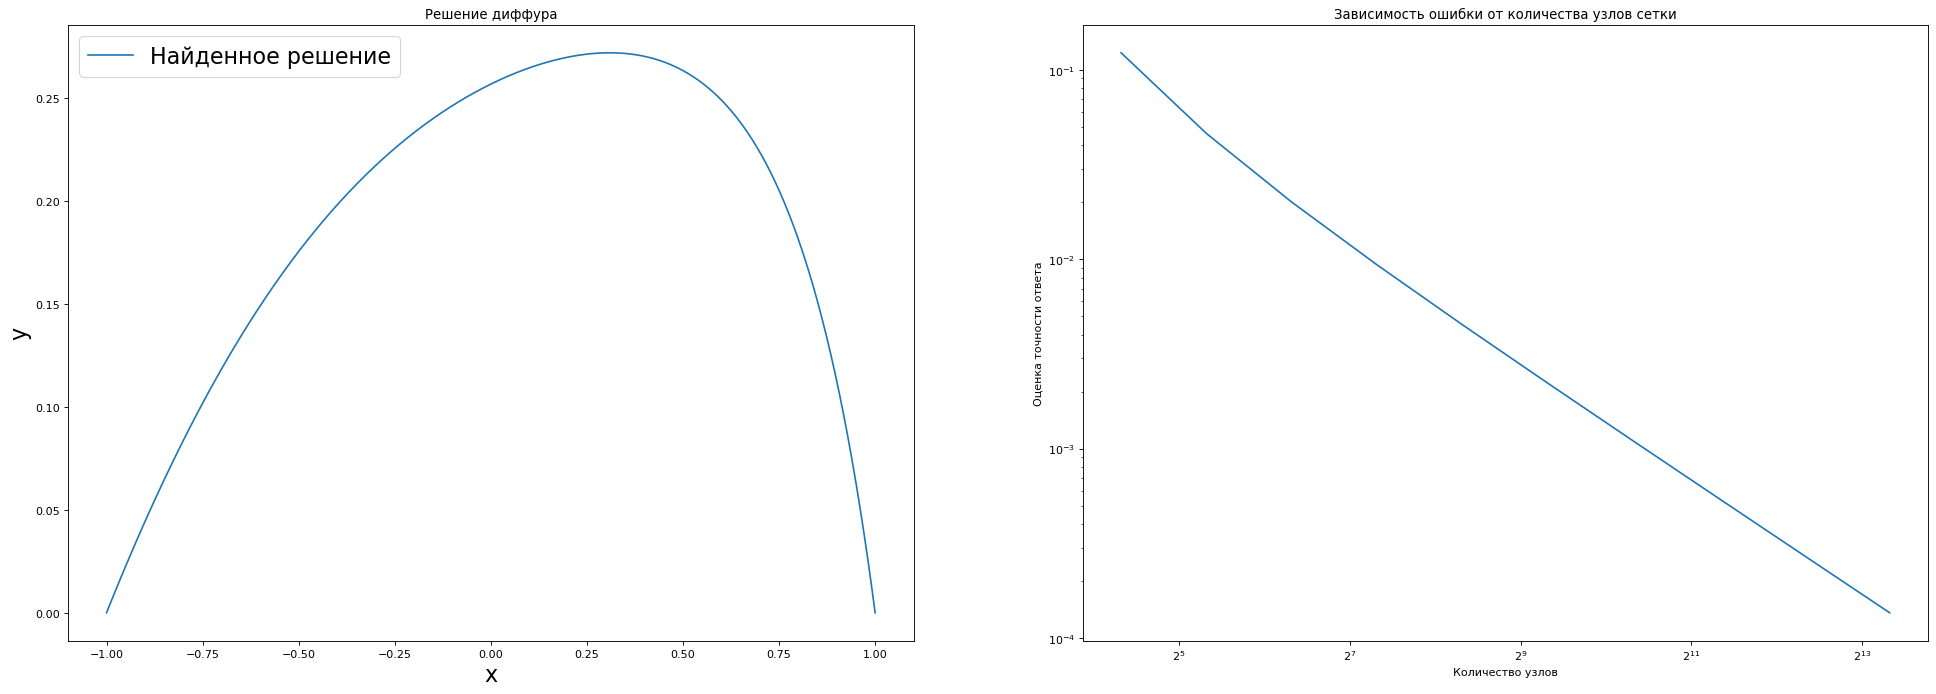

In [80]:
# Вариант 6, (x−2)/(x+ 2)u′′+xu′+ (1−sin(x))u=x2, u(−1) = u(1) = 0.
p = lambda x: (x - 2) / (x + 2)
q = lambda x: x
r = lambda x: 1 - sin(x)
f = lambda x: x ** 2

a, b = -1, 1
alpha, beta = 0, 0
x, intervals, errors = solve(a, b, p, q, r, f, alpha, beta, 1e-6, max_iterations=10)
plot(a, b, x, intervals, errors)

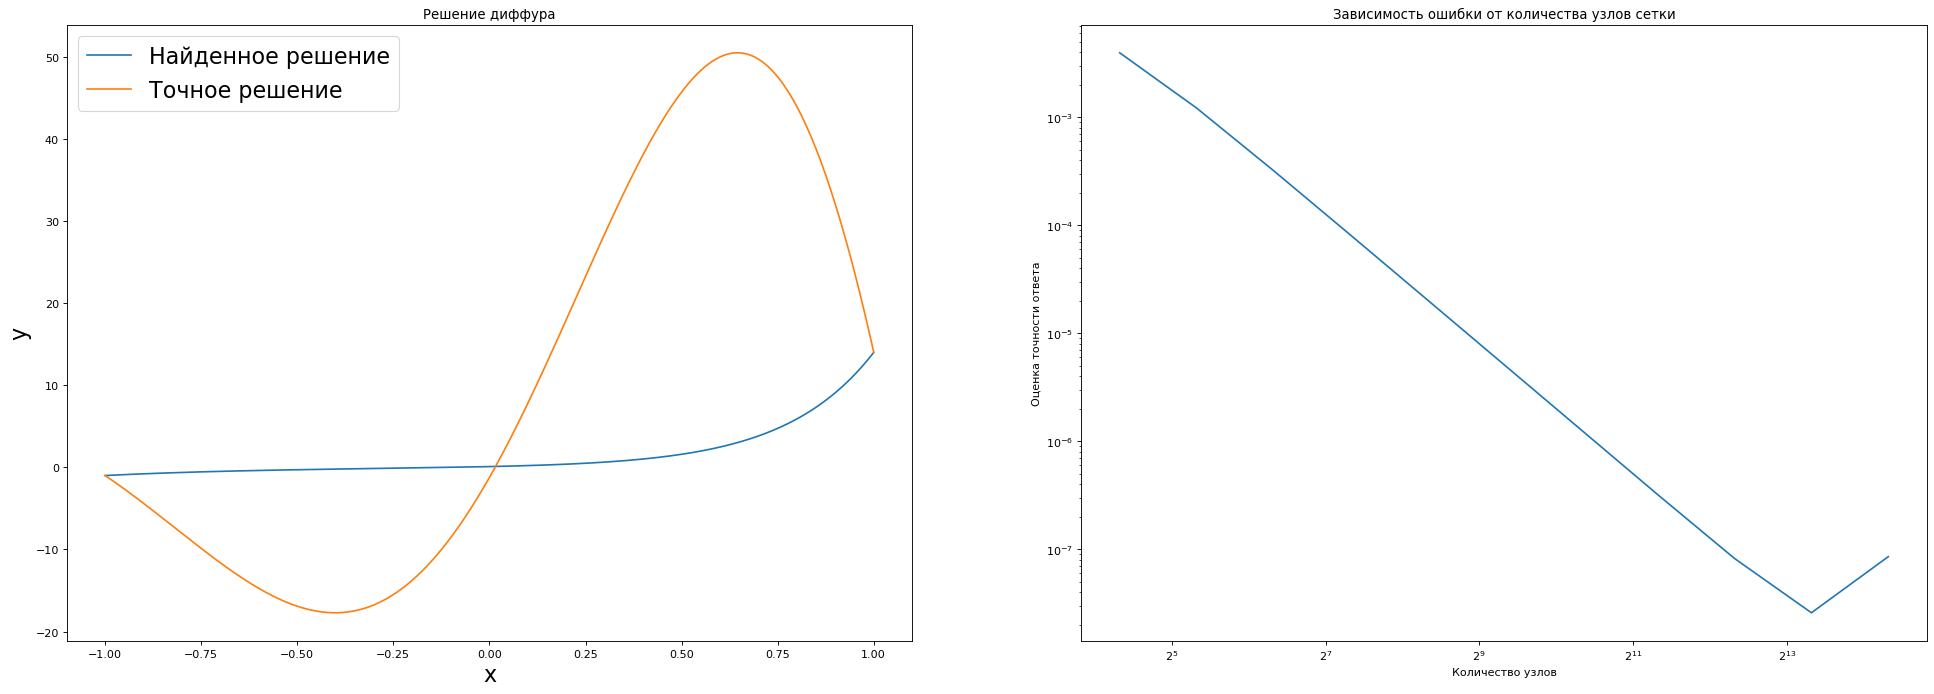

In [96]:
# y'' - 2y' + 10y = 0
p = lambda x: 1
q = lambda x: -2
r = lambda x: 10
f = lambda x: 0
expected = lambda x: exp(x - 1) / sin(6) * (14 * sin(3 * x + 3) - exp(2) * sin(3 - 3 * x))
expected = np.vectorize(expected)
a, b = -1, 1
alpha, beta = -1, 14
x, intervals, errors = solve(a, b, p, q, r, f, alpha, beta, 1e-8, max_iterations=11)
plot(a, b, x, intervals, errors, expected)

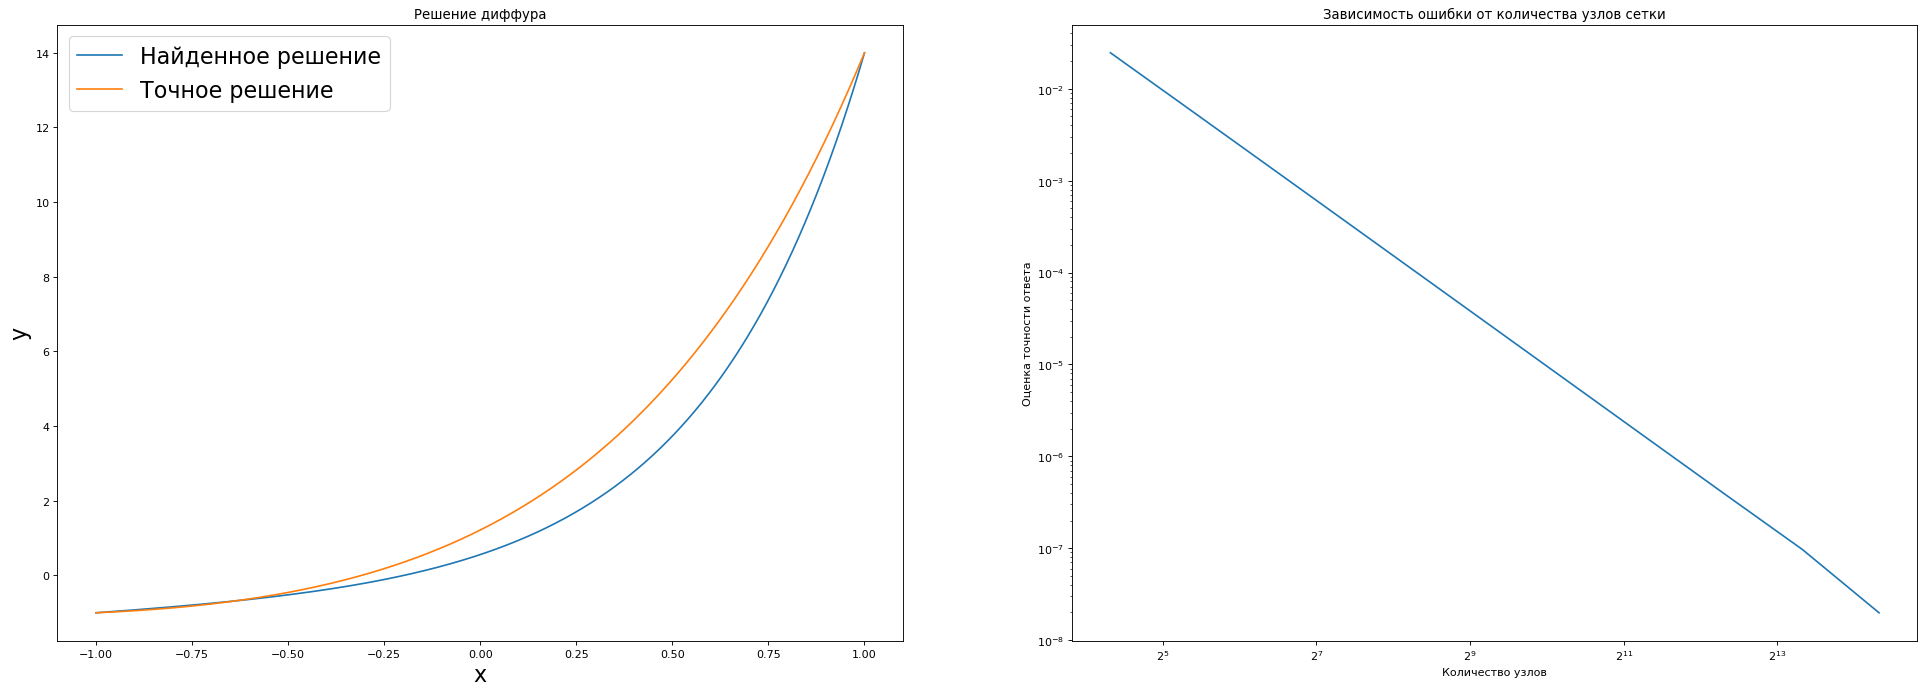

In [100]:
# y'' - 2y' + 1y = 0
p = lambda x: 1
q = lambda x: -2
r = lambda x: 1
f = lambda x: 0
expected = lambda x: 0.5 *  exp(x - 1) * (math.e ** 2 * (x - 1) + 14 * (x + 1))
expected = np.vectorize(expected)
a, b = -1, 1
alpha, beta = -1, 14
x, intervals, errors = solve(a, b, p, q, r, f, alpha, beta, 1e-8, max_iterations=11)
plot(a, b, x, intervals, errors, expected)

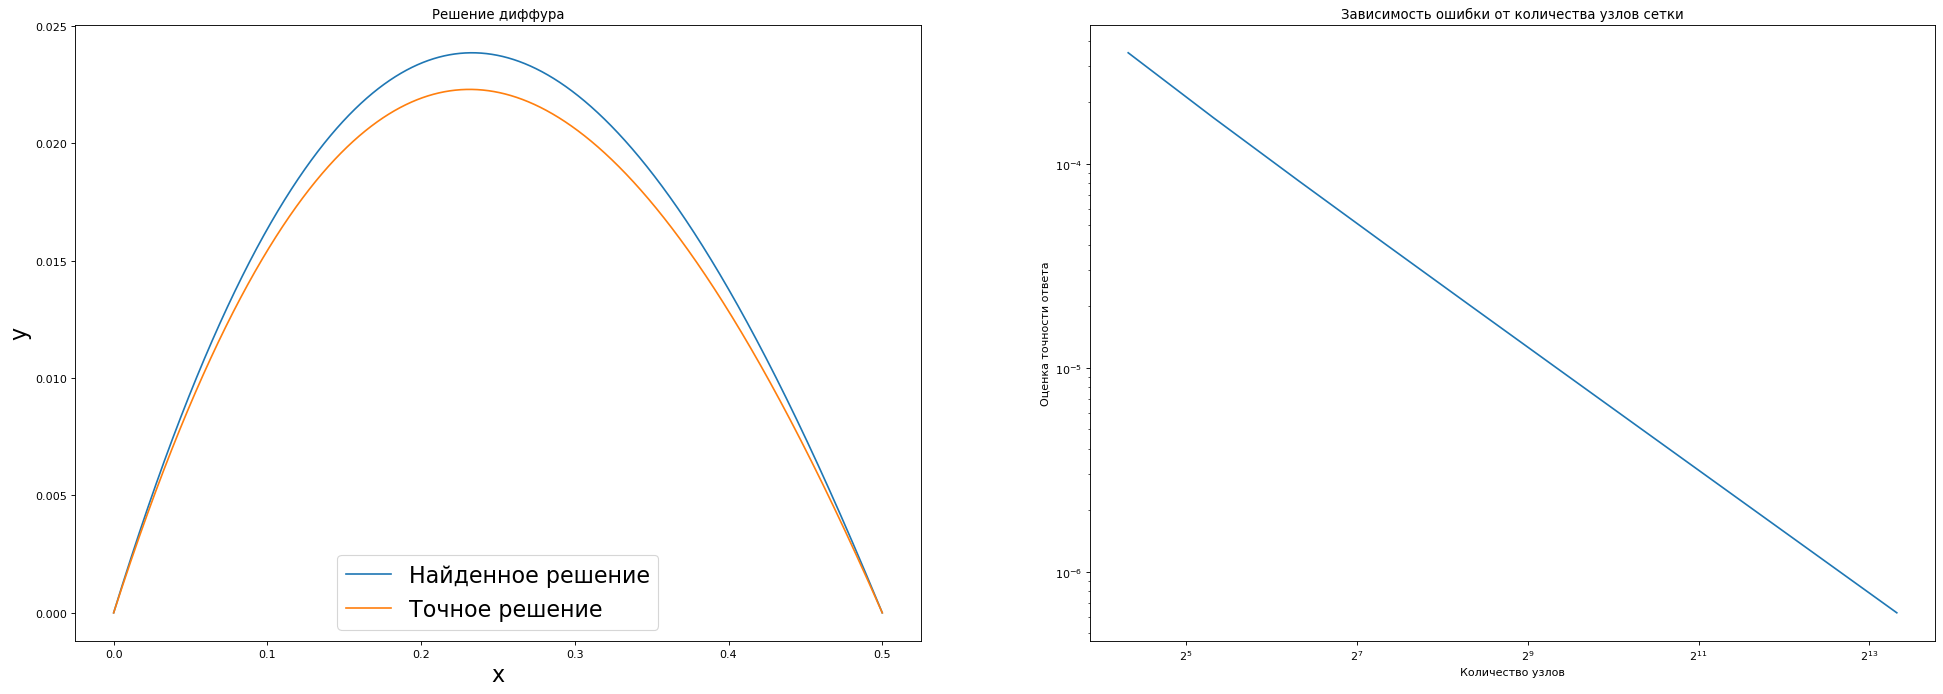

In [88]:
# {(x - 1) y''(x) - x y'(x) + y(x) = (x - 1)^2, y(0) = 0, y(1/2) = 0}
p = lambda x: x - 1
q = lambda x: -x
r = lambda x: 1
f = lambda x: (x - 1) ** 2
expected = lambda x: -x ** 2 - 2 * sqrt(math.e) * x + (5 * x) / 2 + exp(x) - 1
expected = np.vectorize(expected)

a, b = 0, 0.5
alpha, beta = 0, 0
x, intervals, errors = solve(a, b, p, q, r, f, alpha, beta, 1e-6, max_iterations=16)
plot(a, b, x, intervals, errors, expected)